# Adaline model (Adaptive Linear Neuron)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(12355)

#### Dataset

In [2]:
dataset = np.array([
    [0.5, 3.4, 0], [-1.3, 2.7, 0], [1.1, 0.5, 0], [-1.0, 6.1, 0], [3.9, 0.8, 0],
    [-0.7, 5.2, 0], [0.2, 2.1, 0], [1.9, 1.7, 0], [0.5, 4.9, 0], [2.1, 3.8, 0],
    [5.2, 6.8, 1], [6.2, 4.5, 1], [7.6, 5.7, 1], [4.8, 4.2, 1], [3.6, 7.1, 1],
    [4.4, 6.1, 1], [7.2, 3.4, 1], [7.3, 2.1, 1], [5.9, 2.9, 1], [7.2, 6.9, 1]
])

points = np.array(dataset[:, :2], dtype=float)
labels = np.array(dataset[:, 2], dtype=int)

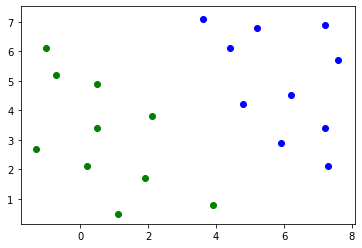

In [3]:
fig = plt.figure()
colors = ['g', 'b']
zeros = np.where(labels == 0)
ones  = np.where(labels == 1)
plt.scatter(points[zeros][:, 0], points[zeros][:, 1], c=colors[0])
plt.scatter(points[ones][:, 0], points[ones][:, 1], c=colors[1])

plt.show()

## Classic Adaline

#### Model

In [4]:
class AdalineClassic:
    def __init__(self, classes, learning_factor=0.015, tolerance=0):
        self.classes = classes
        self.learning_factor = learning_factor
        self.tolerance = tolerance
        self.weights = np.random.rand(3) - np.array([0.5, 0.5, 0.5])
    
    def train(self, data, labels, verbose=False):
        incorrect = self.tolerance + 1
        iters_fuse = 250
        incorrect_hist = []
        
        while incorrect > self.tolerance:
            incorrect = 0
            
            if iters_fuse < 0:
                print("Failed to train the neuron")
                break
            
            for i in range(len(data)):
                X_vec = np.hstack((data[i], [1]))
                true_class = self._discrimination(labels[i])
                
                self.weights += self.learning_factor *\
                                (true_class - self._compute(X_vec)) *\
                                X_vec
            
            for i in range(len(data)):
                X_vec = np.hstack((data[i], [1]))
                prediction = self._activation(self._compute(X_vec))
                true_class = self._discrimination(labels[i])
                
                if prediction != true_class:
                    incorrect += 1
            
            incorrect_hist += [incorrect]
            iters_fuse -= 1
        
        if verbose:
            print("Incorrect answers in consecutive iterations:")
            print(incorrect_hist)
    
    def predict_class(self, point):
        X_vec = np.hstack((point, [1]))
        prediction = self._activation(self._compute(X_vec))
        
        if prediction < 0: return self.classes[0]
        else:              return self.classes[1]
    
    def decisive_boundary_val(self, x):
        y = - self.weights[0] / self.weights[1] * x - self.weights[2] / self.weights[1]
        return y
    
    def _compute(self, X_vec):
        y = np.dot(self.weights, X_vec)
        return y
    
    def _discrimination(self, label):
        if   label == self.classes[0]: return -1.
        elif label == self.classes[1]: return 1.
    
    def _activation(self, x):
        if x > 0.: return 1.
        else:      return -1.

#### Training

In [5]:
adaline_cl = AdalineClassic(classes=(0, 1))
adaline_cl.train(points, labels, verbose=True)

Incorrect answers in consecutive iterations:
[10, 10, 10, 10, 8, 7, 7, 6, 3, 3, 3, 2, 2, 1, 1, 1, 1, 0]


#### Visualization

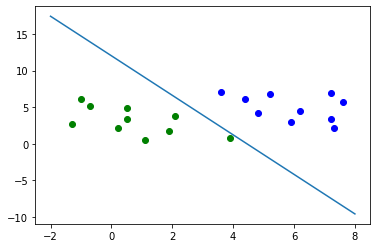

In [6]:
xs = np.linspace(-2., 8., 11)

fig = plt.figure()
colors = ['g', 'b']
zeros = np.where(labels == 0)
ones  = np.where(labels == 1)
plt.scatter(points[zeros][:, 0], points[zeros][:, 1], c=colors[0])
plt.scatter(points[ones][:, 0], points[ones][:, 1], c=colors[1])
plt.plot(xs, [adaline_cl.decisive_boundary_val(x) for x in xs])

plt.show()

## RLS-based Adaline (Recursive Least Squares)

#### Model

In [7]:
class AdalineRLS:
    def __init__(self, classes, forgeting_factor=0.5, tolerance=0):
        self.classes = classes
        self.forgeting_factor = forgeting_factor
        self.tolerance = tolerance
        self.weights = np.random.rand(3) - np.array([0.5, 0.5, 0.5])
    
    def train(self, data, labels, gamma_factor=1., verbose=False):
        incorrect = self.tolerance + 1
        iters_fuse = 250
        incorrect_hist = []
        
        data = np.hstack((data, np.ones(data.shape[0]).reshape(-1, 1)))
        P = gamma_factor * np.identity(data.shape[1])
        
        while incorrect > self.tolerance:
            incorrect = 0
            
            if iters_fuse < 0:
                print("Failed to train the neuron")
                break
            
            for i in range(len(data)):
                X_vec = data[i].reshape(-1, 1)
                prediction = self._activation(self._compute(X_vec))
                true_class = self._discrimination(labels[i])
                
                error_factor = true_class - prediction
                g = (P @ X_vec) / (self.forgeting_factor + X_vec.T @ P @ X_vec)
                P = (1. / self.forgeting_factor) *\
                    (np.identity(data.shape[1]) - g @ X_vec.T) * P
                
                self.weights += error_factor * g.reshape(1, -1).flatten()
            
            for i in range(len(data)):
                X_vec = data[i]
                prediction = self._activation(self._compute(X_vec))
                true_class = self._discrimination(labels[i])
                
                if prediction != true_class:
                    incorrect += 1
            
            incorrect_hist += [incorrect]
            iters_fuse -= 1
        
        if verbose:
            print("Incorrect answers in consecutive iterations:")
            print(incorrect_hist)
    
    def predict_class(self, point):
        X_vec = np.hstack((point, [1]))
        prediction = self._activation(self._compute(X_vec))
        
        if prediction < 0: return self.classes[0]
        else:              return self.classes[1]
    
    def decisive_boundary_val(self, x):
        y = - self.weights[0] / self.weights[1] * x - self.weights[2] / self.weights[1]
        return y
    
    def _compute(self, X_vec):
        y = np.dot(self.weights, X_vec)
        return y
    
    def _discrimination(self, label):
        if   label == self.classes[0]: return -1.
        elif label == self.classes[1]: return 1.
    
    def _activation(self, x):
        if x > 0.: return 1.
        else:      return -1.

#### Training

In [8]:
adaline_rls = AdalineRLS(classes=(0, 1))
adaline_rls.train(points, labels, verbose=True)

Incorrect answers in consecutive iterations:
[10, 2, 1, 8, 1, 0]


#### Visualization

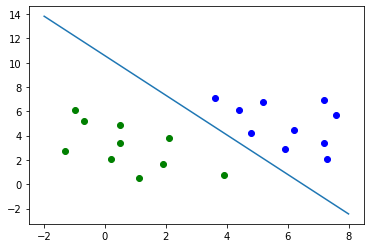

In [9]:
xs = np.linspace(-2., 8., 11)

fig = plt.figure()
colors = ['g', 'b']
zeros = np.where(labels == 0)
ones  = np.where(labels == 1)
plt.scatter(points[zeros][:, 0], points[zeros][:, 1], c=colors[0])
plt.scatter(points[ones][:, 0], points[ones][:, 1], c=colors[1])
plt.plot(xs, [adaline_rls.decisive_boundary_val(x) for x in xs])

plt.show()